In [232]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Data Visualization

The objective of this notebook is to create a recommendation system for the [book-crossing dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). The idea is to use the vector (userId, bookId, rating) to make a judgement whether a new costumer will like such book or not.

In [233]:
ratings = pd.read_csv('/Users/thiagodesouza/Codes/book_rec_system/BX-Book-Ratings.csv', encoding='latin-1', 
                      low_memory=False, sep=';', names=['user_id', 'isbn', 'rating'])

users = pd.read_csv('/Users/thiagodesouza/Codes/book_rec_system/BX-Users.csv', encoding='latin-1', 
                    low_memory=False, sep=';', names=['user_id', 'location', 'age'])

books = pd.read_csv('/Users/thiagodesouza/Codes/book_rec_system/BX-Books.csv', encoding='latin-1',
                   low_memory=False, sep=';',escapechar='\\', names=['isbn', 'book_title' ,'book_author','year_of_publication', 
                                                     'publisher', 'img_s', 'img_m', 'img_l'])

In [234]:
ratings.head(5)

,user_id,isbn,rating
0,User-ID,ISBN,Book-Rating
1,276725,034545104X,0
2,276726,0155061224,5
3,276727,0446520802,0
4,276729,052165615X,3


In [235]:
users.head(5)

,user_id,location,age
0,User-ID,Location,Age
1,1,"nyc, new york, usa",NaN
2,2,"stockton, california, usa",18
3,3,"moscow, yukon territory, russia",NaN
4,4,"porto, v.n.gaia, portugal",17


In [236]:
books.head(5)

,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
0,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
3,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
4,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...


As one can see, the data is separated into three different tables: `ratings` (userId, isbn, rating), `users` (userId, location, age), and `books` (isbn, book title, book author, year of publication, publisher, image small, image medium, image large).

# Preprocessing the data

In this section, we will clean the data. First, notice the first row for each table is just the name of each column, so we drop them.

In [237]:
users = users.drop(users.index[0])
ratings = ratings.drop(ratings.index[0])
books = books.drop(books.index[0])

users.head(5)

,user_id,location,age
1,1,"nyc, new york, usa",NaN
2,2,"stockton, california, usa",18
3,3,"moscow, yukon territory, russia",NaN
4,4,"porto, v.n.gaia, portugal",17
5,5,"farnborough, hants, united kingdom",NaN


In [238]:
users.info()
print('\n')
ratings.info()
print('\n')
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 1 to 278858
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   278858 non-null  object
 1   location  278858 non-null  object
 2   age       168096 non-null  object
dtypes: object(3)
memory usage: 6.4+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 1 to 1149780
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   user_id  1149780 non-null  object
 1   isbn     1149780 non-null  object
 2   rating   1149780 non-null  object
dtypes: object(3)
memory usage: 26.3+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 1 to 271379
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 271379 non-null  object
 1   book_title           271379 non-null  

Notice that the column `age` in `users` contains 110,762 `NULL` values, which correspond to costumers' response that did not include any age number

In [239]:
users.isnull().sum()

user_id          0
location         0
age         110762
dtype: int64

To deal with that, we could drop such entries. Such approach loses information about many costumers. Instead, we will change the `NaN` values for the mean of the remaining values. To do that, we first convert the data type of each column to its respective type.

In [240]:
users['age'] = users['age'].astype(float)
users['user_id'] = users['user_id'].astype(int)
ratings['user_id'] = ratings['user_id'].astype(int)
ratings['rating'] = ratings['rating'].astype(float)

Now, notice that the table also contains extrapolating values for the user's age, such as 3 or 231. Again, instead of ignoring such values, we will change them to the mean.

In [241]:
users.loc[(users.age <4)]

,user_id,location,age
220,220,"bogota, bogota, colombia",0.0
470,470,"indianapolis, indiana, usa",0.0
562,562,"adfdaf, australian capital territory, albania",0.0
613,613,"ankara, n/a, turkey",1.0
671,671,"jeddah, jeddah, saudi arabia",1.0
...,...,...,...
276693,276693,"hunan, guizhou, china",2.0
276785,276785,"bolton, england, united kingdom",1.0
276890,276890,"dorset, england, united kingdom",0.0
277076,277076,"batam, riau, indonesia",3.0


In [242]:
users.loc[(users.age > 99)]

,user_id,location,age
1289,1289,"san jose, california, usa",103.0
1323,1323,"milano, lombardia, italy",104.0
1579,1579,"akure, ondo/nigeria, nigeria",231.0
3085,3085,"zürich, switzerland, switzerland",104.0
3211,3211,"le mesnil saint denis, yvelines, france",119.0
...,...,...,...
276048,276048,"wien, wien, austria",127.0
276353,276353,"hillsdale, new york, usa",104.0
277108,277108,"quinto, ticino, switzerland",104.0
277504,277504,"san diego, california, usa",103.0


In [243]:
users.loc[(users.age <4) | (users.age > 99)] = np.nan

mean = users.age.mean()

users.age.fillna(inplace=True, value=mean)

Let's take a quick look into the stats of `users` table.

In [244]:
users.age.describe()

count    278858.000000
mean         34.738741
std          10.544792
min           4.000000
25%          29.000000
50%          34.738741
75%          35.000000
max          99.000000
Name: age, dtype: float64

It looks just fine, with around 279,000 entries.

For `ratings`, fortunately it does not need any preprocessing

In [245]:
ratings.isnull().sum()

user_id    0
isbn       0
rating     0
dtype: int64

Taking a look into `books`, one notices that its numbers are just fine. However, one book has no author assigned, and two books have no publisher. Let's see which books are those.

In [246]:
books.isnull().sum()

isbn                   0
book_title             0
book_author            1
year_of_publication    0
publisher              2
img_s                  0
img_m                  0
img_l                  0
dtype: int64

In [247]:
# checking books that have no publisher
books.loc[books.publisher.isnull(),:]

,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
128897,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
129044,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...


Googling those books, we quickly get those their publisher, and we are able to replace the `NaN` entries for their respective publishers.

In [248]:
books.loc[books.isbn=='193169656X','publisher']='Mundania Press LLC'
books.loc[books.isbn=='1931696993','publisher']='Novelbooks Incorporated'

We can do the same process for the book whose author is missing.

In [249]:
books.loc[books.book_author.isnull(),:]

,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
187701,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


In [250]:
books.loc[books.isbn=='9627982032','book_author']='Larissa Anne Downe'


Just a sanity check, let's take a look into the `year_of_publication` column. Notice that we change the datatypes.

In [251]:
books['year_of_publication'] = books['year_of_publication'].astype(int)

books.year_of_publication.describe()

count    271379.000000
mean       1959.756050
std         258.011363
min           0.000000
25%        1989.000000
50%        1995.000000
75%        2000.000000
max        2050.000000
Name: year_of_publication, dtype: float64

Notice that some books have its year of publication assigned to 2050 while others have 0. As these values are invalid for the dataset (which goes up to 2004), we, in order to avoid losing information, will replace these values for the mean year (1960).

In [252]:
books.loc[(books.year_of_publication>2004) | (books.year_of_publication == 0)] = books.year_of_publication.mean().round()

### Merging dataframes

In this section, we merge the three dataframes into a single table so we can do the analysis.

In [253]:
import seaborn as sns

# merging users and ratings on 'user_id'
tot_df = pd.merge(users, ratings, on='user_id')

# merging tot_df and books on 'isbn'
tot_df = pd.merge(tot_df,books, on='isbn')

tot_df.head()



,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
0,2.0,"stockton, california, usa",18.000000,0195153448,0.0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,8.0,"timmins, ontario, canada",34.738741,0002005018,5.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,11400.0,"ottawa, ontario, canada",49.000000,0002005018,0.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
3,11676.0,"n/a, n/a, n/a",34.738741,0002005018,8.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
4,41385.0,"sudbury, ontario, canada",34.738741,0002005018,0.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


Let's quickly check the linear correlation (Pearson) between the variables.

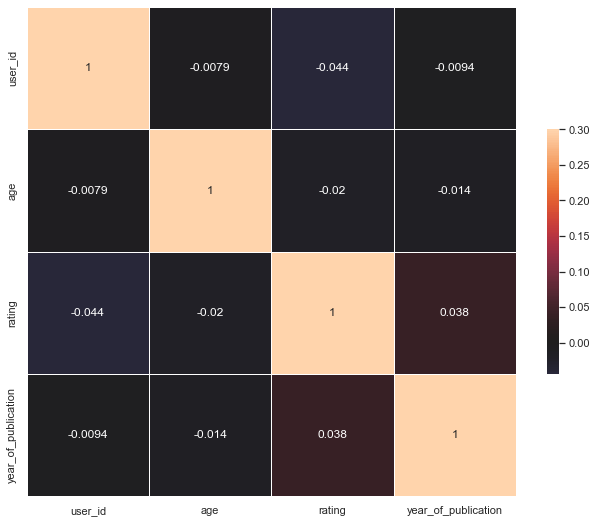

In [254]:
corr = tot_df.corr(method='pearson')

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, annot=True, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('', fontsize='xx-large')
plt.show()


As expected, none of the numerical variables is correlated to each other.

### Splitting location

This section will focus on divinding the location into three parts: city, state, country. 

In [255]:
locs = tot_df.location.str.split(',', n=2, expand=True)
locs.columns = ['city', 'state', 'country']

locs

,city,state,country
0,stockton,california,usa
1,timmins,ontario,canada
2,ottawa,ontario,canada
3,n/a,n/a,n/a
4,sudbury,ontario,canada
...,...,...,...
1012568,dallas,texas,usa
1012569,dallas,texas,usa
1012570,dallas,texas,usa
1012571,dallas,texas,usa


In [256]:
tot_df['city'] = locs['city']
tot_df['state'] = locs['state']
tot_df['country'] = locs['country']

tot_df.head()

,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,city,state,country
0,2.0,"stockton, california, usa",18.000000,0195153448,0.0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,stockton,california,usa
1,8.0,"timmins, ontario, canada",34.738741,0002005018,5.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,timmins,ontario,canada
2,11400.0,"ottawa, ontario, canada",49.000000,0002005018,0.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,ottawa,ontario,canada
3,11676.0,"n/a, n/a, n/a",34.738741,0002005018,8.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,n/a,n/a,n/a
4,41385.0,"sudbury, ontario, canada",34.738741,0002005018,0.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,sudbury,ontario,canada


### Dropping columns 

Now, we drop the columns we won't consider in our models.

In [257]:
tot_df.drop(['location', 'img_l','img_s', 'img_m'], inplace=True, axis=1)

tot_df

,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,city,state,country
0,2.0,18.000000,0195153448,0.0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,stockton,california,usa
1,8.0,34.738741,0002005018,5.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,timmins,ontario,canada
2,11400.0,49.000000,0002005018,0.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,ottawa,ontario,canada
3,11676.0,34.738741,0002005018,8.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,n/a,n/a,n/a
4,41385.0,34.738741,0002005018,0.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,sudbury,ontario,canada
...,...,...,...,...,...,...,...,...,...,...,...
1012568,278851.0,33.000000,0743203763,0.0,As Hogan Said . . . : The 389 Best Things Anyo...,Randy Voorhees,2000,Simon &amp; Schuster,dallas,texas,usa
1012569,278851.0,33.000000,0767907566,5.0,All Elevations Unknown: An Adventure in the He...,Sam Lightner,2001,Broadway Books,dallas,texas,usa
1012570,278851.0,33.000000,0884159221,7.0,Why stop?: A guide to Texas historical roadsid...,Claude Dooley,1985,Lone Star Books,dallas,texas,usa
1012571,278851.0,33.000000,0912333022,7.0,The Are You Being Served? Stories: 'Camping In...,Jeremy Lloyd,1997,Kqed Books,dallas,texas,usa


### Understanding underlying structure of data

This section will focus now on understanding the data itself, and how it was built.

In [258]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='darkgrid')

Let's plot a histogram of the ratings given:

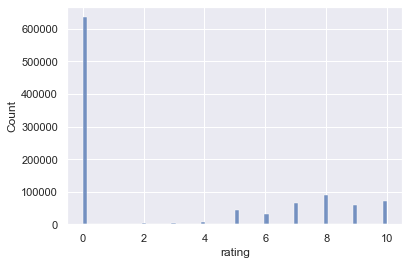

In [259]:
sns.histplot(x='rating', data=tot_df)
plt.show()

The much greater amount of books given the rating 0 is explained by the fact that 0 was given as the default value whenever a costumer did not fill the rating box. The rating scale, however, goes from 1 up to 10. Let's take a look on the real ratings.

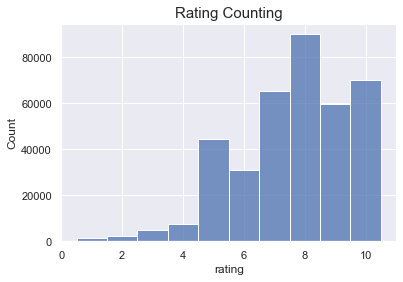

In [260]:
true_rat = tot_df[['rating']].copy()

true_rat = true_rat.loc[true_rat.rating != 0]

sns.histplot(x='rating', data=true_rat, discrete=True)
plt.title('Rating Counting', fontsize=15)
plt.show()

In [261]:
true_rat.rating.describe()

count    376521.000000
mean          7.628185
std           1.841102
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: rating, dtype: float64

### Multiple ISBN numbers

Another issue is that many books appear under different publishers or other factors, which give them a different ISBN number, even though they are the exactly same book. For example, here are the top 10 books with the greater number of different ISBNs:

In [262]:
grouped = tot_df.groupby('book_title').isbn.nunique().sort_values(ascending=False)[:10]
grouped

book_title
Selected Poems                    25
Little Women                      22
Dracula                           20
Adventures of Huckleberry Finn    20
Wuthering Heights                 20
The Secret Garden                 18
The Night Before Christmas        18
Pride and Prejudice               17
Masquerade                        16
Jane Eyre                         16
Name: isbn, dtype: int64

This is a problem, since the model will consider such books to be essentially different. In order to address this problem, we create a dictionary mapping the title of the book to a unique ISBN, which, in this case, will be the first to appear on the table of that book. 

Notice that some books may share the same title but are by different authors. For this reason, the dictionary key will be (book title, book author). To check, make sure to go for the column `unique_isbn`

In [263]:
def get_unique_isbn(df):
    
    def helper(row):
        # if book_title already on the dictionary, just return the isbn 
        if isbn := dc.get((row['book_title'], row['book_author']),None):
            return isbn
        
        # otherwise, insert the ((book_title, book_author):isbn) 
        # pair on dictionary and return the isbn
        else:
            dc[(row['book_title'], row['book_author'])] = row.isbn
            return row.isbn
    dc = {}
    df['unique_isbn'] = df.apply(helper, axis=1)
    return df

tot_df = get_unique_isbn(tot_df)

In [264]:
tot_df.loc[tot_df.book_title == 'Selected Poems'].head(10)

,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,city,state,country,unique_isbn
214239,3837.0,21.000000,081120958X,8.0,Selected Poems,William Carlos Williams,1985,New Directions Publishing Corporation,san francisco,california,usa,081120958X
214240,250925.0,33.000000,081120958X,0.0,Selected Poems,William Carlos Williams,1985,New Directions Publishing Corporation,milton,ontario,canada,081120958X
444608,11676.0,34.738741,0670809179,5.0,Selected Poems,John Ashbery,1985,Penguin USA,n/a,n/a,n/a,0670809179
444609,167189.0,43.000000,0670809179,0.0,Selected Poems,John Ashbery,1985,Penguin USA,coburg,oregon,usa,0670809179
564036,22154.0,36.000000,0811201465,8.0,Selected Poems,K. Patchen,1957,New Directions Publishing Corporation,cleveland,ohio,usa,0811201465
564037,23872.0,22.000000,0811201465,9.0,Selected Poems,K. Patchen,1957,New Directions Publishing Corporation,tulsa,oklahoma,usa,0811201465
572588,23768.0,45.000000,0679750800,0.0,Selected Poems,Rita Dove,1993,Vintage Books USA,st. louis,missouri,usa,0679750800
572589,77819.0,59.000000,0679750800,7.0,Selected Poems,Rita Dove,1993,Vintage Books USA,lexington,kentucky,usa,0679750800
572590,91832.0,34.738741,0679750800,0.0,Selected Poems,Rita Dove,1993,Vintage Books USA,miami,florida,usa,0679750800
572591,129716.0,30.000000,0679750800,10.0,Selected Poems,Rita Dove,1993,Vintage Books USA,tallahassee,florida,usa,0679750800


In [265]:
tot_df.loc[tot_df.book_title == 'Dracula'].head(10)

,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,city,state,country,unique_isbn
156598,2295.0,21.000000,156619301X,0.0,Dracula,Bram Stoker,1994,Dorset Press,el sobrante,california,usa,156619301X
156599,45585.0,34.738741,156619301X,0.0,Dracula,Bram Stoker,1994,Dorset Press,san diego,california,usa,156619301X
156600,224138.0,34.738741,156619301X,0.0,Dracula,Bram Stoker,1994,Dorset Press,carlsbad,california,usa,156619301X
233012,4622.0,18.000000,055321148X,0.0,Dracula,Bram Stoker,1983,Bantam,norfolk,virginia,usa,156619301X
233013,29743.0,22.000000,055321148X,6.0,Dracula,Bram Stoker,1983,Bantam,la mirada,california,usa,156619301X
233014,69554.0,34.738741,055321148X,10.0,Dracula,Bram Stoker,1983,Bantam,new bern,north carolina,,156619301X
233015,142524.0,36.000000,055321148X,0.0,Dracula,Bram Stoker,1983,Bantam,detroit,michigan,usa,156619301X
408429,11676.0,34.738741,0140052801,9.0,Dracula,Bram Stoker,1992,Penguin USA,n/a,n/a,n/a,156619301X
408430,12194.0,34.738741,0140052801,10.0,Dracula,Bram Stoker,1992,Penguin USA,redford,michigan,usa,156619301X
408431,110112.0,31.000000,0140052801,7.0,Dracula,Bram Stoker,1992,Penguin USA,houston,texas,usa,156619301X


In [266]:
tot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1012573 entries, 0 to 1012572
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   user_id              1012573 non-null  float64
 1   age                  1012573 non-null  float64
 2   isbn                 1012573 non-null  object 
 3   rating               1012573 non-null  float64
 4   book_title           1012573 non-null  object 
 5   book_author          1012573 non-null  object 
 6   year_of_publication  1012573 non-null  int64  
 7   publisher            1012573 non-null  object 
 8   city                 1012573 non-null  object 
 9   state                1012573 non-null  object 
 10  country              1012573 non-null  object 
 11  unique_isbn          1012573 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 100.4+ MB


For the models, let's only get the rating that are valid (greater than or equal to 1). This got us to 376,000 entries.

In [267]:
tot_df = tot_df.loc[tot_df.rating >=1]

tot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376521 entries, 1 to 1012572
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              376521 non-null  float64
 1   age                  376521 non-null  float64
 2   isbn                 376521 non-null  object 
 3   rating               376521 non-null  float64
 4   book_title           376521 non-null  object 
 5   book_author          376521 non-null  object 
 6   year_of_publication  376521 non-null  int64  
 7   publisher            376521 non-null  object 
 8   city                 376521 non-null  object 
 9   state                376521 non-null  object 
 10  country              376521 non-null  object 
 11  unique_isbn          376521 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 37.3+ MB


# Recommender systems

This section we build different models and test their accuracy

In [268]:
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

## Observation

Since the model will be based on (user_id, book_id, rating), we have to give each user_id a number from 0 to *total number of users*, and each book_id a number from 0 to *total number of books*.

In [269]:
tot_df.user_id = pd.Categorical(tot_df.user_id)
tot_df['new_user_id'] = tot_df.user_id.cat.codes

tot_df.unique_isbn = pd.Categorical(tot_df.unique_isbn)
tot_df['new_isbn'] = tot_df.unique_isbn.cat.codes

tot_df.head(10)

/var/folders/6n/0vgsmrcs3k75rldnm523j4600000gp/T/ipykernel_81325/1092152560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tot_df.user_id = pd.Categorical(tot_df.user_id)
/var/folders/6n/0vgsmrcs3k75rldnm523j4600000gp/T/ipykernel_81325/1092152560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tot_df['new_user_id'] = tot_df.user_id.cat.codes
/var/folders/6n/0vgsmrcs3k75rldnm523j4600000gp/T/ipykernel_81325/1092152560.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,city,state,country,unique_isbn,new_user_id,new_isbn
1,8.0,34.738741,0002005018,5.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,timmins,ontario,canada,0002005018,0,34
3,11676.0,34.738741,0002005018,8.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,n/a,n/a,n/a,0002005018,2656,34
5,67544.0,30.000000,0002005018,8.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,toronto,ontario,canada,0002005018,16317,34
8,116866.0,34.738741,0002005018,9.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,ottawa,,,0002005018,28128,34
9,123629.0,34.738741,0002005018,9.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,kingston,ontario,canada,0002005018,29736,34
11,200273.0,34.738741,0002005018,8.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,comber,ontario,canada,0002005018,47841,34
12,210926.0,34.738741,0002005018,9.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,guelph,ontario,canada,0002005018,50495,34
13,219008.0,60.000000,0002005018,7.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,halifax,nova scotia,canada,0002005018,52380,34
14,263325.0,27.000000,0002005018,6.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,fredericton,new brunswick,canada,0002005018,63129,34
16,2954.0,71.000000,0060973129,8.0,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,wichita,kansas,usa,0060973129,698,4158


## 1st model - ANN

This first model tests an Artificial Neural Network (ANN) to make the predictions.

In [270]:
user_ids = tot_df.new_user_id.values
isbn_ids = tot_df.new_isbn.values
ratings = tot_df.rating.values

In [271]:
Nusers = len(set(user_ids))
Nisbn = len(set(isbn_ids))

print(Nusers)
print(Nisbn)


66800
136911


Our architecture will consist of two input vectors (each 1x1) corresponding to the user_id and the book_id (isbn). Then, we will convert the the vectors using one-hot enconding. Then, after flattenning them, we will concatenate them and pass through a dense layer (1024 perceptrons) with activation ReLU, and final layer with just one output and no activation.

In [272]:
emb_dim = 10

u = Input(shape=(1,)) # user_id
b = Input(shape=(1,)) # isbn

# convert to vecs (n_samples x 1 x emb_dim)
u_emb = Embedding(Nusers, emb_dim)(u) 
b_emb = Embedding(Nisbn, emb_dim)(b)

# flatten both to (n_samples x emb_dim)
u_emb = Flatten()(u_emb)
b_emb = Flatten()(b_emb)

# concat into a feature vector (n_samples x 2emb_dim)
x = Concatenate()([u_emb, b_emb])

# ANN
x = Dense(1024, activation='relu')(x)
x = Dense(1)(x) # final layer should be a linear layer

The measure of error will be the MSE since it is a regression model. Additionally, we will use RMSE as well. Here, we use a learning rate $\gamma = 0.08$, momentum factor $\alpha = 0.09$, and 25 epochs. 

In [273]:
model = Model(inputs=[u,b], outputs=x)
model.compile(
    loss='mse',
    optimizer=SGD(learning_rate=0.08, momentum=0.09),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [274]:
# creating both training and testing data
# one could use sklearn.model_selection.train_test_split

from sklearn.utils import shuffle

users_ids, isbn_ids, ratings = shuffle(user_ids, isbn_ids, ratings) 

Ntrain = int(0.8*len(ratings))

train_user = user_ids[:Ntrain]
train_isbn = isbn_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_isbn = isbn_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

Let's train

In [275]:
r = model.fit(x=[train_user, train_isbn], 
              y=train_ratings,
              epochs=25,
              batch_size=1024,
              verbose=2,
              validation_data=[[test_user, test_isbn], test_ratings]
)

Epoch 1/25
295/295 - 1s - loss: 3.3888 - root_mean_squared_error: 1.8409 - val_loss: 3.3940 - val_root_mean_squared_error: 1.8423 - 1s/epoch - 4ms/step
Epoch 2/25
295/295 - 1s - loss: 3.3874 - root_mean_squared_error: 1.8405 - val_loss: 3.3911 - val_root_mean_squared_error: 1.8415 - 795ms/epoch - 3ms/step
Epoch 3/25
295/295 - 1s - loss: 3.3833 - root_mean_squared_error: 1.8394 - val_loss: 3.3874 - val_root_mean_squared_error: 1.8405 - 794ms/epoch - 3ms/step
Epoch 4/25
295/295 - 1s - loss: 3.3733 - root_mean_squared_error: 1.8367 - val_loss: 3.3775 - val_root_mean_squared_error: 1.8378 - 793ms/epoch - 3ms/step
Epoch 5/25
295/295 - 1s - loss: 3.3512 - root_mean_squared_error: 1.8306 - val_loss: 3.3611 - val_root_mean_squared_error: 1.8333 - 795ms/epoch - 3ms/step
Epoch 6/25
295/295 - 1s - loss: 3.3145 - root_mean_squared_error: 1.8206 - val_loss: 3.3453 - val_root_mean_squared_error: 1.8290 - 791ms/epoch - 3ms/step
Epoch 7/25
295/295 - 1s - loss: 3.2668 - root_mean_squared_error: 1.8074 

We got down to a **RMSE = 2.01**. Take a look on the chart below

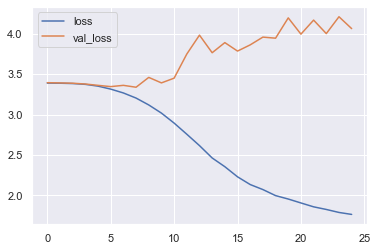

In [276]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

To judge the effectiveness of the method, let's try cross validation for the ANN with a k-fold of 3:

Fold 1
Fold 2
Fold 3


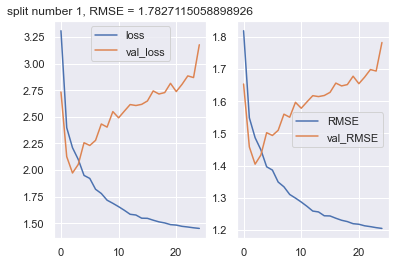

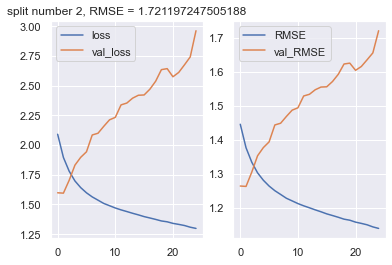

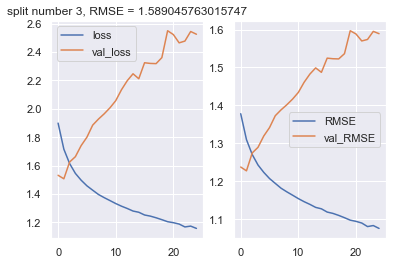

Mean value for RMSE: 1.6976515054702759


In [277]:
from sklearn.model_selection import KFold
import seaborn as sns

kf = KFold(n_splits=3)


kf.get_n_splits(user_ids)

rmse_vals = []

c=1
for train_index, test_index in kf.split(user_ids):
    model = Model(inputs=[u,b], outputs=x)
    model.compile(
        loss='mse',
        optimizer=SGD(learning_rate=0.08, momentum=0.09),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
    print(f'Fold {c}')
    (u_train,u_test) = user_ids[train_index], user_ids[test_index]
    (b_train, b_test) = isbn_ids[train_index], isbn_ids[test_index]
    rating_train, rating_test = ratings[train_index], ratings[test_index]
    
    r = model.fit(x=[u_train, b_train], 
              y=rating_train,
              epochs=25,
              batch_size=1024,
              verbose=0,
              validation_data=[[u_test, b_test], rating_test]
              )
    rmse = model.evaluate(x=[u_test, b_test], y=rating_test, verbose=0)[1]
    rmse_vals.append(rmse)
    
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.set_title(f'split number {c}, RMSE = {rmse}')
    ax1.plot(r.history['loss'], label='loss')
    ax1.plot(r.history['val_loss'], label='val_loss')
    ax1.legend()
    
    ax2.plot(r.history['root_mean_squared_error'], label='RMSE')
    ax2.plot(r.history['val_root_mean_squared_error'], label='val_RMSE')
    ax2.legend()
    
    c+=1


    
plt.show()

print(f'Mean value for RMSE: {np.mean(rmse_vals)}')
    

    

We achieve a final **RMSE** = 1.70 for the ANN model.

## 2nd model - SVD w/ Collaborative Filtering

This second model we use the SVD w/ Collab. Filtering. This algorithm was used in the Netflix Prize. It is a model that performs well under the assumption that the rating can be well explained by only the user_id and book_id. A more comprehensive explanation of the model can be found [here](http://buzzard.pugetsound.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf).

In [278]:
import numpy as np

In [279]:
user_rat_book = tot_df[['new_user_id','new_isbn', 'rating']]
user_rat_book.columns = ['user_id', 'isbn', 'rating']
user_rat_book

,user_id,isbn,rating
1,0,34,5.0
3,2656,34,8.0
5,16317,34,8.0
8,28128,34,9.0
9,29736,34,9.0
...,...,...,...
1012567,66797,67468,7.0
1012569,66797,82593,5.0
1012570,66797,99933,7.0
1012571,66797,103068,7.0


Let's import `surprise`, which is a library focused on recommender systems.

In [280]:
from surprise import Reader, Dataset, SVD, NMF, model_selection, accuracy, KNNBasic

In [281]:
reader = Reader(rating_scale=(1,10))

data = Dataset.load_from_df(user_rat_book, reader)


Let's apply cross validation to it, with k-fold of 5:

In [282]:
model = SVD()

model_selection.validation.cross_validate(model, data, measures=['rmse'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6380  1.6247  1.6407  1.6372  1.6337  1.6349  0.0056  
Fit time          18.42   19.16   19.83   20.13   20.30   19.57   0.69    
Test time         0.45    0.54    0.53    1.15    0.58    0.65    0.25    


{'test_rmse': array([1.63803625, 1.62469974, 1.6406876 , 1.63723926, 1.63373653]),
 'fit_time': (18.422394275665283,
  19.161125659942627,
  19.832416772842407,
  20.132784128189087,
  20.29972505569458),
 'test_time': (0.45032286643981934,
  0.5431098937988281,
  0.5265388488769531,
  1.1475069522857666,
  0.578728199005127)}

We achieve a final **RMSE** = 1.63. Let's test on some train/test sets:

In [283]:
# set test set to 20%.
trainset, testset = model_selection.train_test_split(data, test_size=0.2)

# Instantiate the SVD model.
model = SVD()

# Train the algorithm on the training set, and predict ratings for the test set
model.fit(trainset)
predictions = model.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.6304


1.6304262587142824

## 3rd model - NMF

The Non-Negative Matrix Factorization (NMF) method is similar to the SVD but tries to factorize the matrix into two non-negative matrix such that their product gives the predicted rating. Let's apply cross validation to it, with k-fold of 5:

In [284]:
model = NMF()

model_selection.validation.cross_validate(model, data, measures=['rmse'], cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.4785  2.4632  2.4807  2.4818  2.4811  2.4771  0.0070  
Fit time          35.23   32.56   34.38   32.01   32.15   33.27   1.30    
Test time         0.52    0.52    0.44    0.41    0.38    0.46    0.06    


{'test_rmse': array([2.47846077, 2.46316172, 2.48074213, 2.48184662, 2.48111174]),
 'fit_time': (35.23426914215088,
  32.55987095832825,
  34.378172874450684,
  32.00805592536926,
  32.146509885787964),
 'test_time': (0.5228910446166992,
  0.5246462821960449,
  0.43695807456970215,
  0.40926504135131836,
  0.3846161365509033)}

We achieve a final **RMSE** = 2.47

## 4th model - KNN

In [285]:
# set test set to 20%.
trainset, testset = model_selection.train_test_split(data, test_size=0.2)

# Instantiate the KNN model.
model = KNNBasic()

# Train the algorithm on the training set, and predict ratings for the test set
model.fit(trainset)
predictions = model.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.9356


1.9356425945824123

We achieve a final **RMSE** = 1.93

## 5th model - Random Forest Regressor

In [291]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tot_df[['new_user_id', 'new_isbn']], tot_df['rating'].ravel(), test_size=0.2)

rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

n = y_test.shape

score = (((y_test - y_pred)**2).sum())/n

print(np.sqrt(score))

[1.78748041]


We achieve a final **RMSE** = 1.78

## 6th model - Extra Trees Regressor

In [293]:
from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor(random_state=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tot_df[['new_user_id', 'new_isbn']], tot_df['rating'].ravel(), test_size=0.2)

etr.fit(X_train, y_train)

y_pred = etr.predict(X_test)

n = y_test.shape

score = (((y_test - y_pred)**2).sum())/n

print(np.sqrt(score))

[1.83251527]


We achieve a final **RMSE** = 1.83